In [82]:
pip install torch torchvision matplotlib numpy torchinfo lightning seaborn


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torchvision.transforms import ToTensor, Compose, Resize, Lambda, RandomHorizontalFlip, RandomRotation
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib.pyplot import subplots
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns




In [4]:
import os
import pandas as pd

Cells_Data = pd.DataFrame(columns=["class", "filepath"])

for root, dirs, files in os.walk("archive"):
    if os.path.basename(root) == "CROPPED":
        class_name = os.path.basename(os.path.dirname(root))
        
        for file in files:
            if file.endswith(".bmp"):
                file_path = os.path.join(root, file)
                Cells_Data = pd.concat([Cells_Data, pd.DataFrame({
                    "class": [class_name],
                    "filepath": [file_path]
                })], ignore_index=True)

"Total de imagens .bmp:", len(Cells_Data)

('Total de imagens .bmp:', 4049)

In [5]:
import os
import pandas as pd

# Caminho base
base_dir = "data/imgmask"

# DataFrame com as colunas desejadas
ImgMask_Data = pd.DataFrame(columns=["class", "filepath"])

# Percorrer todas as subpastas e arquivos
for root, dirs, files in os.walk(base_dir):
    # Pega o nome da subpasta como classe (nível imediatamente abaixo de imgmask)
    class_name = os.path.basename(root)
    
    # Ignora a pasta base "imgmask" em si
    if class_name == "imgmask":
        continue

    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(root, file)
            ImgMask_Data = pd.concat([
                ImgMask_Data,
                pd.DataFrame({
                    "class": [class_name],
                    "filepath": [file_path]
                })
            ], ignore_index=True)

print("✅ Dataset criado com sucesso!")
print("Total de imagens .png:", len(ImgMask_Data))
print(ImgMask_Data.head())


✅ Dataset criado com sucesso!
Total de imagens .png: 4049
             class                                      filepath
0  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_628.png
1  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_685.png
2  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_367.png
3  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_410.png
4  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_490.png


In [6]:
from PIL import Image
from torch.utils.data import Dataset

class CellsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        # Mapeia cada classe para um índice numérico
        self.class_to_idx = {cls: i for i, cls in enumerate(self.data["class"].unique())}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, "filepath"]
        label = self.class_to_idx[self.data.loc[idx, "class"]]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [7]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomRotation

transform = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToTensor()
])


In [8]:
full_dataset = CellsDataset(ImgMask_Data, transform=transform)

# tamanhos do split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # para reprodutibilidade
)


In [9]:
val_size = int(0.2 * train_size)
train_size_final = train_size - val_size

train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size_final, val_size],
    generator=torch.Generator().manual_seed(42)
)


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


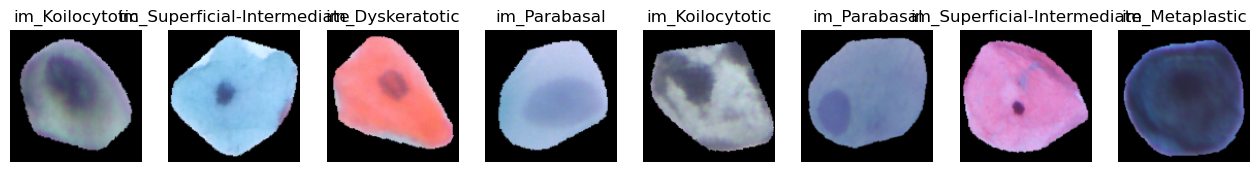

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# pegar um batch do dataloader
images, labels = next(iter(train_loader))

# converter tensor para numpy (para visualização)
images = images.numpy().transpose((0, 2, 3, 1))  # [B, H, W, C]
labels = labels.numpy()

# função auxiliar para mostrar imagens
def show_images(imgs, labels, class_names, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Recupera os nomes das classes do dataset original
class_names = list(full_dataset.class_to_idx.keys())

# mostra 8 imagens aleatórias
show_images(images, labels, class_names, n=8)


In [12]:
class BuildingBlock(nn.Module):
    def __init__(self ,
                    in_channels ,
                    out_channels):
        super(BuildingBlock , self).__init__ ()
        self.conv = nn.Conv2d(in_channels=in_channels ,
                                out_channels=out_channels ,
                                kernel_size =(3 ,3),
                                padding='same')
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU ()
        self.pool = nn.MaxPool2d(kernel_size =(2 ,2))
    def forward(self , x):
      return self.pool(self.activation(self.bn(self.conv(x))))

In [93]:
sizes = []

for path in Cells_Data["filepath"].sample(200):  # pega 200 amostras pra não demorar
    with Image.open(path) as img:
        sizes.append(img.size)  # (w, h)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
print(sizes_df.describe())


            width      height
count  200.000000  200.000000
mean   224.745000  204.355000
std    101.994039   95.290558
min     72.000000   60.000000
25%    134.500000  124.000000
50%    205.500000  183.000000
75%    297.750000  276.000000
max    513.000000  553.000000


In [94]:
class CVD_Model(nn.Module):
    def __init__(self):
        super(CVD_Model, self).__init__()
        sizes = [(3, 32), (32, 64), (64, 128)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_) for in_, out_ in sizes])
        
        self.gap = nn.AdaptiveAvgPool2d((7, 7))  # garante 7x7 em qualquer entrada
        
        self.output = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*128, 1024),   # usa o último número de filtros da conv
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        val = self.conv(x)
        val = self.gap(val)
        val = torch.flatten(val, 1)
        return self.output(val)


In [95]:
cvd_model = CVD_Model()
summary(cvd_model ,
input_data= torch.randn(1, 3, 224, 224),
col_names =['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVD_Model                                [1, 3, 224, 224]          [1, 5]                    --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 128, 28, 28]          --
│    └─BuildingBlock: 2-1                [1, 3, 224, 224]          [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 3, 224, 224]          [1, 32, 224, 224]         896
│    │    └─BatchNorm2d: 3-2             [1, 32, 224, 224]         [1, 32, 224, 224]         64
│    │    └─ReLU: 3-3                    [1, 32, 224, 224]         [1, 32, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [1, 32, 224, 224]         [1, 32, 112, 112]         --
│    └─BuildingBlock: 2-2                [1, 32, 112, 112]         [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 32, 112, 112]         [1, 64, 112, 112]         18,496
│    │    └─BatchNorm2d: 3-6  

In [96]:
class LitCVDModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CVD_Model() 
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001)


In [97]:
model = LitCVDModel()


checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-cvd-model",
    verbose=True
)

trainer = Trainer(
    accelerator="auto",  
    devices=1,
    max_epochs=120,
    precision=16,         
    log_every_n_steps=10,
    callbacks=[checkpoint_callback]
    
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | CVD_Model        | 7.0 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
7.0 M     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
model_unet_ida = LitCVDModel.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(model, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.63456791639328
        test_loss           0.8768470287322998
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8768470287322998, 'test_acc': 0.63456791639328}]

In [13]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_conv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [14]:
class UNetEncoderClassifier(nn.Module):
  
    def __init__(self, in_ch=3, feat=[16, 32, 64, 128]):  
        super().__init__()

        self.downs = nn.ModuleList()
        self.pool  = nn.MaxPool2d(2, 2)

        in_channels = in_ch
        for f in feat:
            self.downs.append(double_conv(in_channels, f))
            in_channels = f

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(in_channels, 5)  

    def forward(self, x):
        for down in self.downs:
            x = down(x)
            x = self.pool(x)

        x = self.gap(x).flatten(1)  
        return self.fc(x)

In [15]:
def teste_tamanho():
    x = torch.randn(1, 1, 128, 128)
    model = UNetEncoderClassifier(in_ch=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
teste_tamanho()


torch.Size([1, 5])
torch.Size([1, 1, 128, 128])


In [16]:
class LitUNetEncoderClassifier(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model   = UNetEncoderClassifier()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, stage):
        x, y = batch
        y = y.long()       
        logits = self(x)                  
        loss   = self.loss_fn(logits, y)

        
        preds = torch.argmax(logits, dim=1)
        acc   = (preds == y).float().mean()

        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_acc",  acc,  prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", patience=3, factor=0.5
        )
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler, "monitor": "val_acc", "interval": "epoch", "frequency":1}}


In [17]:
model_unet_ida = LitUNetEncoderClassifier()

checkpoint_callback_unet_ida = ModelCheckpoint(
    monitor="val_acc",
    mode = "max",
    save_top_k = 1,
    filename="best-unet-ida-classifier")

trainer = Trainer(
    accelerator = "auto",
    devices=1,
    max_epochs=100,
    precision=16,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_unet_ida]
)

trainer.fit(model_unet_ida, train_dataloaders=train_loader, val_dataloaders=val_loader)


/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
model_unet_ida = LitUNetEncoderClassifier.load_from_checkpoint(checkpoint_callback_unet_ida.best_model_path)
trainer.test(model_unet_ida, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9456790089607239
        test_loss           0.16278256475925446
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.16278256475925446, 'test_acc': 0.9456790089607239}]

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# CLASSIFICANDO EM 3 CLASSES


In [98]:
import torch
import torch.nn as nn
import lightning as L
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

In [99]:
class UNetEncoderClassifier(nn.Module):
  
    def __init__(self, in_ch=3, feat=[16, 32, 64, 128]):  
        super().__init__()

        self.downs = nn.ModuleList()
        self.pool  = nn.MaxPool2d(2, 2)

        in_channels = in_ch
        for f in feat:
            self.downs.append(double_conv(in_channels, f))
            in_channels = f

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(in_channels, 3)  

    def forward(self, x):
        for down in self.downs:
            x = down(x)
            x = self.pool(x)

        x = self.gap(x).flatten(1)  
        return self.fc(x)

In [ ]:
class LitUNetEncoderClassifier(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = UNetEncoderClassifier()

        # ⚖️ Definição dos pesos das classes
        # Supondo 5 classes: 0, 1, 2, 3, 4
        weights = torch.tensor([1.0, 1.0, 20.0], dtype=torch.float)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, stage):
        x, y = batch
        y = y.long()       
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_acc", acc, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = ReduceLROnPlateau(
            optimizer, mode="max", patience=3, factor=0.5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_acc"}
        }


In [101]:
mapa = {
    'im_Superficial-Intermediate': 'Normal',
    'im_Parabasal': 'Normal',
    'im_Metaplastic': 'Maligna',
    'im_Koilocytotic': 'Benigna',
    'im_Dyskeratotic': 'Benigna'
}

ImgMask_Data['categoria'] = ImgMask_Data['class'].map(mapa)

In [102]:
class CellsDatasetGeral(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        # Mapeia cada classe para um índice numérico
        self.ctg_to_idx = {ctg: i for i, ctg in enumerate(self.data["categoria"].unique())}
        self.idx_to_cat = {i: ctg for ctg, i in self.ctg_to_idx.items()}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, "filepath"]
        label = self.ctg_to_idx[self.data.loc[idx, "categoria"]]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [103]:
geral_dataset = CellsDatasetGeral(ImgMask_Data, transform=transform)

# tamanhos do split
train_size_geral = int(0.8 * len(geral_dataset))
test_size_geral = len(geral_dataset) - train_size_geral

train_dataset_geral, test_dataset_geral = random_split(
    geral_dataset,
    [train_size_geral, test_size_geral],
    generator=torch.Generator().manual_seed(42)  # para reprodutibilidade
)


In [104]:
val_size_geral = int(0.2 * train_size_geral)
train_size_final_geral = train_size_geral - val_size_geral

train_dataset_geral, val_dataset_geral = random_split(
    train_dataset_geral,
    [train_size_final_geral, val_size_geral],
    generator=torch.Generator().manual_seed(42)
)


In [105]:
train_loader_geral = DataLoader(train_dataset_geral, batch_size=32, shuffle=True)
val_loader_geral = DataLoader(val_dataset_geral, batch_size=32)
test_loader_geral = DataLoader(test_dataset_geral, batch_size=32)


In [106]:
print("ctg_to_idx:", geral_dataset.ctg_to_idx)
print("idx_to_cat:", geral_dataset.idx_to_cat)


ctg_to_idx: {'Benigna': 0, 'Normal': 1, 'Maligna': 2}
idx_to_cat: {0: 'Benigna', 1: 'Normal', 2: 'Maligna'}


In [107]:
model_geral = LitCVDModel()


checkpoint_callback_geral = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-cvd-model",
    verbose=True
)

trainer = Trainer(
    accelerator="auto",  
    devices=1,
    max_epochs=120,
    precision=16,         
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_geral]
    
)

trainer.fit(model_geral, train_dataloaders=train_loader_geral, val_dataloaders=val_loader_geral)


/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | CVD_Model        | 7.0 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
7.0 M     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [108]:
model_geral = LitCVDModel.load_from_checkpoint(checkpoint_callback_geral.best_model_path)
trainer.test(model_geral, dataloaders=test_loader_geral)

IsADirectoryError: [Errno 21] Is a directory: '/home/al.igor.alves/Modelos/Cervical_'

In [109]:
model_unet_ida_geral = LitUNetEncoderClassifier()

checkpoint_callback_unet_ida_geral = ModelCheckpoint(
    monitor="val_acc",
    mode = "max",
    save_top_k = 1,
    filename="best-unet-ida-classifier")

trainer = Trainer(
    accelerator = "auto",
    devices=1,
    max_epochs=101,
    precision=16,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_unet_ida_geral]
)

trainer.fit(model_unet_ida_geral, train_dataloaders=train_loader_geral, val_dataloaders=val_loader_geral)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params | Mode 
----------------------------------------------------------
0 | model   | UNetEncoderClassifier | 294 K  | train
1 | loss_fn | CrossEntropyLoss      | 0      | train
----------------------------------------------------------
294 K     Trainable params
0         Non-trainable params
294 K     Total params
1.178     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=101` reached.


In [110]:
model_unet_ida_geral = LitUNetEncoderClassifier.load_from_checkpoint(checkpoint_callback_unet_ida_geral.best_model_path)
trainer.test(model_unet_ida_geral, dataloaders=test_loader_geral)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9654321074485779
        test_loss           0.11851180344820023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.11851180344820023, 'test_acc': 0.9654321074485779}]

In [111]:
# Obtendo as categorias a partir do dicionário mapa
class_names = list(mapa.values())
class_names


['Normal', 'Normal', 'Maligna', 'Benigna', 'Benigna']

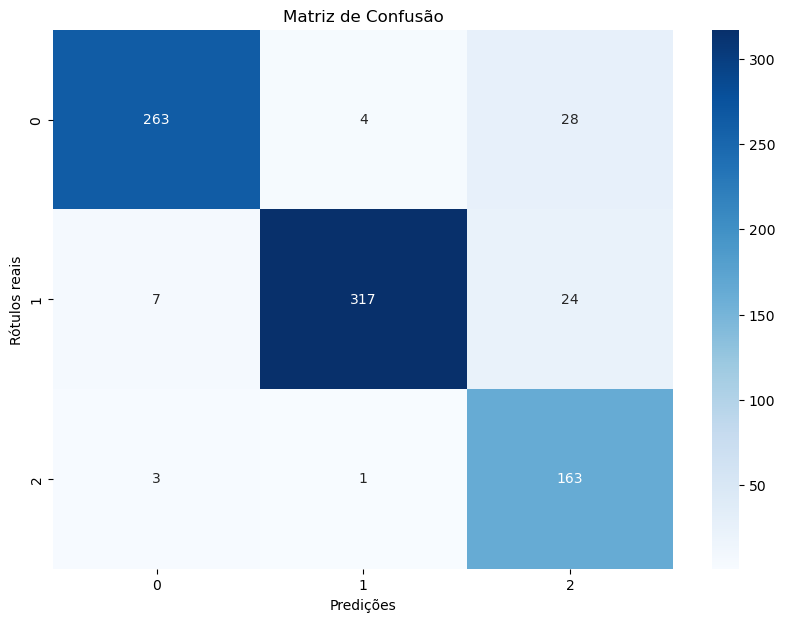

In [ ]:
import matplotlib.pyplot as plt
model_unet_ida_geral.eval()  # Coloca o modelo em modo de avaliação

true_labels = []
pred_labels = []

# Iterando sobre o DataLoader de teste para coletar predições
with torch.no_grad():
    for batch in test_loader_geral:
        inputs, labels = batch
        outputs = model_unet_ida_geral(inputs)

        # Se o modelo for uma rede de classificação, aplicamos argmax
        _, predicted = torch.max(outputs, 1)

        # Adicionando os rótulos reais e predições às listas
        true_labels.extend(labels.numpy())
        pred_labels.extend(predicted.numpy())

# Calculando a matriz de confusão
cm = confusion_matrix(true_labels, pred_labels)

# Plotando a matriz de confusão com Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(cm)), yticklabels=np.arange(len(cm)))
plt.xlabel('Predições')
plt.ylabel('Rótulos reais')
plt.title('Matriz de Confusão')
plt.show()

In [112]:
# Obtendo as categorias a partir do dicionário mapa
class_names = list(mapa.values())
class_names


['Normal', 'Normal', 'Maligna', 'Benigna', 'Benigna']

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve,
    auc, f1_score, recall_score, precision_score, accuracy_score
)

# --- Definir nomes de classes corretos ---
# Ordem correta de acordo com os índices do modelo: 0 = Maligna, 1 = Normal, 2 = Benigna
class_names = ["Abnormal", "Normal", "Benign"]

# --- Avaliação ---

with torch.no_grad():
    for inputs, labels in test_loader_geral:
        outputs = model_unet_ida_geral(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
        probs_all.extend(probs.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
probs_all = np.array(probs_all)

# --- Matriz de Confusão ---
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predictions")
plt.ylabel("")
plt.title("Confusion Matrix")
plt.show()

# --- Relatório de Classificação ---
print("Relatório de Classificação:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# --- Métricas globais ---
acc = accuracy_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels, average='weighted')
precision = precision_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Acurácia: {acc:.4f}")
print(f"Precisão (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

# --- Curvas ROC separadas por classe ---
n_classes = len(class_names)
colors = ["red", "green", "darkorange"]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels == i, probs_all[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel("Falso Positivo (FPR)")
    plt.ylabel("Verdadeiro Positivo (TPR)")
    plt.title(f"Curva ROC - Classe: {class_names[i]}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


NameError: name 'test_loader_geral' is not defined

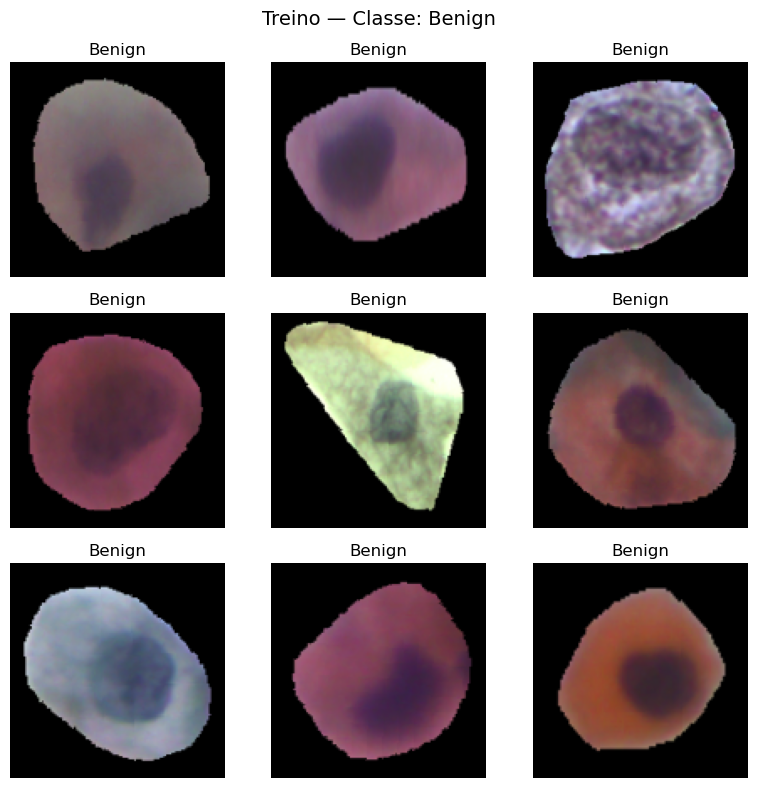

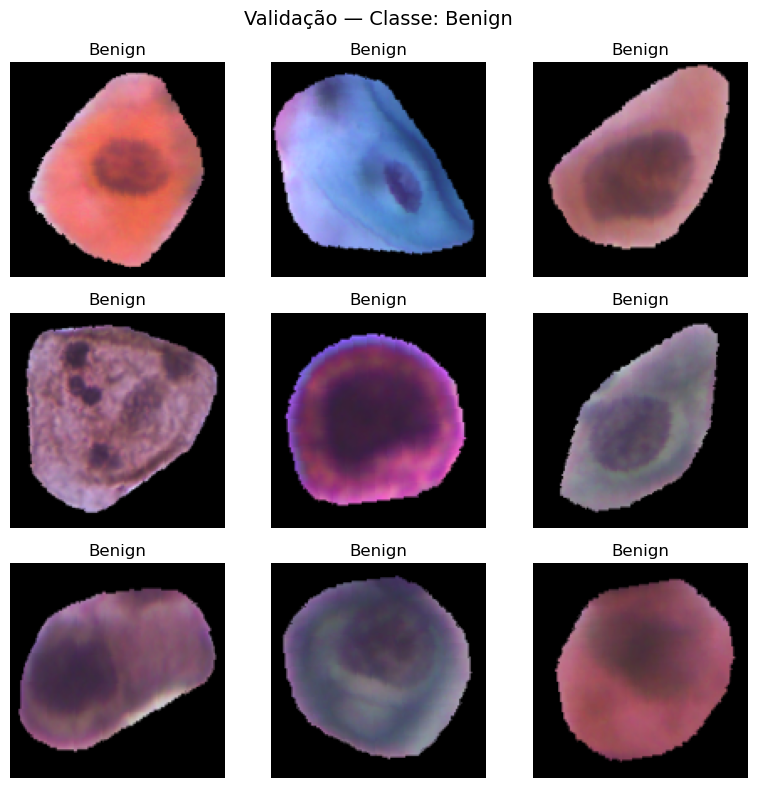

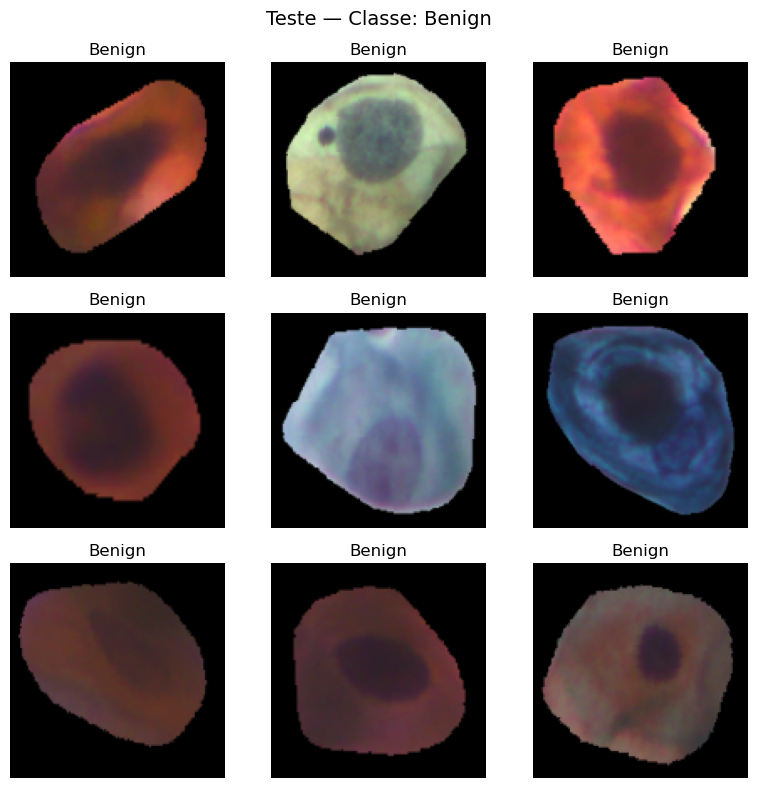

In [117]:
import torch
import matplotlib.pyplot as plt

# --- Nome da classe desejada ---
classe_desejada = 0  # 0 → "Benign"
nome_classe = "Benign"

# --- Função auxiliar para mostrar imagens de um DataLoader ---
def mostrar_imagens_classe(loader, nome_loader, classe_desejada, nome_classe, num_imgs=9):
    model_unet_ida_geral.eval()
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    count = 0

    with torch.no_grad():
        for inputs, labels in loader:
            for i in range(len(labels)):
                if labels[i].item() == classe_desejada:
                    img = inputs[i].permute(1, 2, 0).cpu().numpy()
                    ax = axes[count]
                    ax.imshow(img)
                    ax.axis("off")
                    ax.set_title(f"{nome_classe}")
                    count += 1
                    if count >= num_imgs:
                        break
            if count >= num_imgs:
                break

    plt.suptitle(f"{nome_loader} — Classe: {nome_classe}", fontsize=14)
    plt.tight_layout()
    plt.show()


# --- Mostrar para treino, validação e teste ---
mostrar_imagens_classe(train_loader_geral, "Treino", classe_desejada, nome_classe)
mostrar_imagens_classe(val_loader_geral, "Validação", classe_desejada, nome_classe)
mostrar_imagens_classe(test_loader_geral, "Teste", classe_desejada, nome_classe)
